## Task 2: Use SageMaker Experiments

In this lab, you set up an experiment using Amazon SageMaker Experiments. You train a machine learning (ML) model using XGBoost, perform hyperparameter tuning to test multiple hyperparameter settings and produce a more accurate model, and evaluate your model’s performance.

### Task 2.1: Setup the environment

Before you start training your model, install any necessary dependencies.


Refer to [Manage Machine Learning with Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html#experiments-features) to learn more about the features of SageMaker Experiments.

In [2]:
#install-dependencies

import boto3
import io
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sagemaker
import sys
import time
import zipfile

from IPython.display import display
from IPython.display import Image
from sagemaker.analytics import ExperimentAnalytics
from sagemaker.inputs import TrainingInput
from sagemaker.session import Session
from sagemaker.experiments.run import Run, load_run
#from sagemaker.utils import unique_name_from_base  #could be used instead of the date-time append approach, to create a unique Experiment name.
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.xgboost.estimator import XGBoost
from time import gmtime, strftime

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sess = boto3.Session()
sm = sess.client('sagemaker')
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/mlasms'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Created S3 bucket: sagemaker-us-west-2-108732882025


Next, import the dataset.

In [3]:
#import-dataset
lab_test_data = pd.read_csv('adult_data_processed.csv')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
lab_test_data.head()

,income,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week
0,0,39,1,2,2,1,2,1,0,0,2174,0,40
1,0,50,2,2,2,0,2,0,0,0,0,0,13
2,0,38,0,0,0,2,0,1,0,0,0,0,40
3,0,53,0,3,6,0,0,0,1,0,0,0,40
4,0,28,0,2,2,0,3,4,1,1,0,0,40


You split the dataset into training (70 percent), validation (20 percent), and test (10 percent) datasets. The training and validation datasets are during training. The test dataset is used in model evaluation after deployment.

To train using Amazon SageMaker, you need to convert the datasets into either the libSVM or CSV format. This lab uses the CSV format for training. 

Refer to [XGBoost Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) for information about the XGBoost algorithm. 
Refer to [Input/Output Interface for the XGBoost Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost) for more information about Input/Output Interface for the XGBoost Algorithm.


In [4]:
#split-dataset
train_data, validation_data, test_data = np.split(
    lab_test_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(lab_test_data)), int(0.9 * len(lab_test_data))],
)

train_data.to_csv('train_data.csv', index=False, header=False)
validation_data.to_csv('validation_data.csv', index=False, header=False)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


You have created two dataset files, named *train_data.csv* and *validation_data.csv*. 
Upload these dataset files to Amazon Simple Storage Service (Amazon S3).

In [5]:
#upload-dataset
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

sagemaker_session = sagemaker.Session()

train_path = S3Uploader.upload('train_data.csv', 's3://{}/{}'.format(bucket, prefix))
validation_path = S3Uploader.upload('validation_data.csv', 's3://{}/{}'.format(bucket, prefix))

train_input = TrainingInput(train_path, content_type='text/csv')
validation_input = TrainingInput(validation_path, content_type='text/csv')

data_inputs = {
    'train': train_input,
    'validation': validation_input
}

### Task 2.2: Create an experiment and run an initial training job

Use SageMaker Experiments to organize, track, compare, and evaluate ML model training experiments through various training components. Refer to [Manage Machine Learning with Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) for more information about SageMaker Experiments. In SageMaker Experiments, these components include data sets, algorithms, hyperparameters, and metrics. 

In this task, you complete the following:
- Create and track the experiment in Amazon SageMaker Studio.
- Create a run to track inputs, parameters, and metrics.

First, create a name for the experiment and give it a description.

In [6]:
#create unique experiment name
create_date = strftime("%m%d%H%M")

lab_6_experiment_name = "lab-6-{}".format(create_date)
description = "Using SageMaker Experiments with the Adult dataset."




Then, define the optional values for a run name and tags.

In [7]:
# create initial run_name
run_name = "lab-6-run-{}".format(create_date)

# define a run_tag
run_tags = [{'Key': 'lab-6', 'Value': 'lab-6-run'}]

print(f"Experiment name - {lab_6_experiment_name},  run name - {run_name}")

Experiment name - lab-6-11051642,  run name - lab-6-run-11051642


### Task 2.3: Train and tune the model using the XGBoost algorithm

The experiment is set up and ready for training. After training is complete, you can analyze the results in SageMaker Studio. In this task, you do the following: 

- Train the XGBoost model.
- Analyze the experiments in SageMaker Studio.
- Tune the model with hyperparameters.
- Analyze the tuning results in SageMaker Studio.

### Task 2.4: Train the XGBoost Model

Now train the model using the XGBoost algorithm and the experiment that you created. 

The hyperparameters that you set are as follows:
- **eta**: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. 
- **gamma**: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger it is, the more conservative the algorithm is.
The eta parameter actually shrinks the feature weights to make the boosting process more conservative.
- **max_depth**: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfit.
- **min_child_weight**: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is.
- **num_round**: The number of rounds (trees) used for boosting. Increasing the trees can increase the model accuracy but increases the risk of overfitting.
- **objective**: Specifies the learning task and the corresponding learning objective.
- **subsample**: Subsample ratio of the training instance. Setting it to 0.5 means that XGBoost randomly collects half of the data instances to grow trees. This prevents overfitting.
- **verbosity**: Verbosity of printing messages. Valid values are 0 (silent), 1 (warning), 2 (info), and 3 (debug).

The training takes approximately 3–4 minutes to run.

Refer to [XGBoost Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) for more information about XGBoost hyperparameters.

In [8]:
from sagemaker import image_uris
container = image_uris.retrieve(framework='xgboost',region=boto3.Session().region_name,version='1.5-1')

# initialize hyperparameters
eta=0.2
gamma=4
max_depth=5
min_child_weight=6
num_round=800
objective='binary:logistic'
subsample=0.8
verbosity=0

hyperparameters = {
        "max_depth":max_depth,
        "eta":eta,
        "gamma":gamma,
        "min_child_weight":min_child_weight,
        "subsample":subsample,
        "verbosity":verbosity,
        "objective":objective,
        "num_round":num_round
}

# Set up the estimator
xgb = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m5.xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sagemaker_session,
    EnableSageMakerMetricsTimeSeries=True,
    hyperparameters=hyperparameters,
    tags = run_tags
)


#Run the training job link to Experiment.
with Run(
    experiment_name=lab_6_experiment_name,
    run_name=run_name,
    tags=run_tags,
    sagemaker_session=sagemaker_session,
) as run:

    run.log_parameters({
                        "eta": eta, 
                        "gamma": gamma, 
                        "max_depth": max_depth,
                        "min_child_weight": min_child_weight,
                        "num_round": num_round,
                        "objective": objective,
                        "subsample": subsample,
                        "verbosity": verbosity
                       })
    
#    you may also specify metrics to log
#    run.log_metric(name="", value=x)

# Train the model associating the training run with the current "experiment"
    xgb.fit(
        inputs = data_inputs
    ) 

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-05-16-42-12-347


2024-11-05 16:42:12 Starting - Starting the training job...
2024-11-05 16:42:28 Starting - Preparing the instances for training...
2024-11-05 16:42:53 Downloading - Downloading input data...
2024-11-05 16:43:23 Downloading - Downloading the training image...
2024-11-05 16:44:04 Training - Training image download completed. Training in progress....
2024-11-05 16:44:42 Uploading - Uploading generated training model
2024-11-05 16:44:42 Completed - Training job completed
..Training seconds: 110
Billable seconds: 110


### Task 2.5: Evaluate model performance pre-tuning

In SageMaker Studio, you can create charts to evaluate your training jobs. For example, after running lab-6 experiments, you can review the validation:logloss_max value in a chart format.

In this lab, you can plot additional metrics in the notebook.

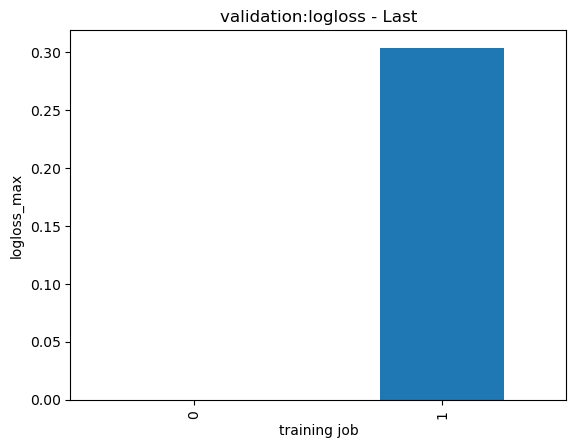

In [9]:
#visualize-training-results-table
run_component_analytics = ExperimentAnalytics(
    experiment_name=lab_6_experiment_name,
    sagemaker_session=Session(sess, sm),
)
run_component_analytics.dataframe()["validation:logloss - Last"].plot(kind="bar", title="validation:logloss - Last", xlabel="training job", ylabel="logloss_max")
plt.show()

### Task 2.6: Tune the model with hyperparameters

You have successfully performed model training using SageMaker Experiments. While training, you can also configure SageMaker to use hyperparameters to significantly affect trained model performance. SageMaker Studio includes various common hyperparameter tuning options for model training. Testing numerous parameters can vary in effectiveness depending on the dataset used. But it can also take a significant amount of time and effort to create the best model.

SageMaker automatic model tuning automates the selection of hyperparameters to optimize training. Refer to [Perform Automatic Model Tuning with SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) for more information about automatic model tuning. To use it, you specify a range, or a list of possible values, for each hyperparameter that you choose to tune. SageMaker automatic model tuning automatically runs multiple training jobs with various hyperparameter settings. It then evaluates the results of each job based on a specified objective metric and selects the hyperparameter settings for future attempts based on previous results. For each tuning job, you specify a maximum number of training jobs, and the tuning completes when that number has been reached.

The hyperparameter ranges that you need set are as follows:
- **alpha**: L1 regularization term on weights. Increasing this value makes models more conservative.
- **eta**: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative.
- **max_depth**: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfit.
- **min_child_weight**: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is.
- **num_round**: The number of rounds (trees) used for boosting. Increasing the trees can increase the model accuracy but increases the risk of overfitting.

Tuning takes approximately 5 minutes to complete.

Refer to [XGBoost Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) for more information about XGBoost hyperparameters.

In [10]:
#tune-model
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# Setup the hyperparameter ranges
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 2),
    'eta': ContinuousParameter(0, 1),
    'max_depth': IntegerParameter(1, 10),
    'min_child_weight': ContinuousParameter(1, 10),
    'num_round': IntegerParameter(100, 1000)
}
# Define the target metric and the objective type (max/min)
objective_metric_name = 'validation:auc'
objective_type='Maximize'
# Define the HyperparameterTuner
tuner = HyperparameterTuner(
    estimator = xgb,
    objective_metric_name = objective_metric_name,
    hyperparameter_ranges = hyperparameter_ranges,
    objective_type = objective_type,
    max_jobs=12,
    max_parallel_jobs=4,
    early_stopping_type='Auto',
)

with load_run(sagemaker_session=sagemaker_session, experiment_name=lab_6_experiment_name, run_name=run_name) as run:
# Tune the model
    tuner.fit(
        inputs = data_inputs,
        job_name = lab_6_experiment_name,
    )
    

INFO:sagemaker.experiments.run:The run (lab-6-run-11051642) under experiment (lab-6-11051642) already exists. Loading it.
INFO:sagemaker:Creating hyperparameter tuning job with name: lab-6-11051642


.....................................................!


### Task 2.7: Evaluate model performance post-tuning

In SageMaker Studio, you can also create charts to evaluate your tuning jobs. For example, after running your lab-6-trial training job, you can look at your objective value, the **validation:auc_max**, in a chart format.

![An image of the validation:error_max charts in SageMaker Studio.](Task_2_3_4.png)

In this lab, view the results from the best tuning job and visualize them using charts in the notebook.

In [11]:
#get_experiment_analytics 
run_component_analytics = ExperimentAnalytics(
    experiment_name=lab_6_experiment_name+"-aws-tuning-job",
    sagemaker_session=Session(sess, sm),
)

run_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,_tuning_objective_metric,alpha,eta,gamma,max_depth,min_child_weight,num_round,objective,subsample,verbosity,ObjectiveMetric - Min,ObjectiveMetric - Max,ObjectiveMetric - Avg,ObjectiveMetric - StdDev,ObjectiveMetric - Last,ObjectiveMetric - Count,validation:auc - Min,validation:auc - Max,validation:auc - Avg,validation:auc - StdDev,validation:auc - Last,validation:auc - Count,train:auc - Min,train:auc - Max,train:auc - Avg,train:auc - StdDev,train:auc - Last,train:auc - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,lab-6-11051642-012-904bf504-aws-training-job,lab-6-11051642-012-904bf504-aws-training-job,arn:aws:sagemaker:us-west-2:108732882025:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m5.xlarge,30.0,validation:auc,0.915062,0.052050,4.0,5.0,5.708467,180.0,binary:logistic,0.8,0.0,0.87307,0.90551,0.896521,0.008730,0.90541,66,0.87307,0.90573,0.896659,0.008736,0.90573,67,0.87913,0.91504,0.904644,0.009665,0.91504,67,text/csv,s3://sagemaker-us-west-2-108732882025/sagemake...,text/csv,s3://sagemaker-us-west-2-108732882025/sagemake...,None,s3://sagemaker-us-west-2-108732882025/sagemake...,[lab-6-11051642-012-904bf504],[lab-6-11051642-aws-tuning-job]
1,lab-6-11051642-011-ccaf4953-aws-training-job,lab-6-11051642-011-ccaf4953-aws-training-job,arn:aws:sagemaker:us-west-2:108732882025:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m5.xlarge,30.0,validation:auc,1.988058,0.057134,4.0,2.0,8.831740,250.0,binary:logistic,0.8,0.0,0.00000,0.88867,0.000000,0.000000,0.90557,0,0.00000,0.88867,0.000000,0.000000,0.90557,0,0.00000,0.89341,0.000000,0.000000,0.91209,0,text/csv,s3://sagemaker-us-west-2-108732882025/sagemake...,text/csv,s3://sagemaker-us-west-2-108732882025/sagemake...,None,s3://sagemaker-us-west-2-108732882025/sagemake...,[lab-6-11051642-011-ccaf4953],[lab-6-11051642-aws-tuning-job]
2,lab-6-11051642-009-f5a94f93-aws-training-job,lab-6-11051642-009-f5a94f93-aws-training-job,arn:aws:sagemaker:us-west-2:108732882025:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m5.xlarge,30.0,validation:auc,0.028140,0.046550,4.0,5.0,3.906710,222.0,binary:logistic,0.8,0.0,0.00000,0.90274,0.000000,0.000000,0.91592,0,0.00000,0.90274,0.000000,0.000000,0.91592,0,0.00000,0.91104,0.000000,0.000000,0.92720,0,text/csv,s3://sagemaker-us-west-2-108732882025/sagemake...,text/csv,s3://sagemaker-us-west-2-108732882025/sagemake...,None,s3://sagemaker-us-west-2-108732882025/sagemake...,[lab-6-11051642-009-f5a94f93],[lab-6-11051642-aws-tuning-job]
3,lab-6-11051642-010-411c506c-aws-training-job,lab-6-11051642-010-411c506c-aws-training-job,arn:aws:sagemaker:us-west-2:108732882025:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m5.xlarge,30.0,validation:auc,0.924972,0.100616,4.0,5.0,8.773983,216.0,binary:logistic,0.8,0.0,0.00000,0.90855,0.000000,0.000000,0.91658,0,0.00000,0.90855,0.000000,0.000000,0.91658,0,0.00000,0.91776,0.000000,0.000000,0.92792,0,text/csv,s3://sagemaker-us-west-2-108732882025/sagemake...,text/csv,s3://sagemaker-us-west-2-108732882025/sagemake...,None,s3://sagemaker-us-west-2-108732882025/sagemake...,[lab-6-11051642-010-411c506c],[lab-6-11051642-aws-tuning-job]
4,lab-6-11051642-006-e357a72a-aws-training-job,lab-6-11051642-006-e357a72a-aws-training-job,arn:aws:sagemaker:us-west-2:108732882025:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m5.xlarge,30.0,validation:auc,1.246172,0.990457,4.0,9.0,4.679351,828.0,binary:logistic,0.8,0.0,0.89058,0.91284,0.910196,0.003864,0.90990,38,0.89058,0.91284,0.910196,0.003864,0.90990,38,0.89924,0.93798,0.930587,0.007916,0.93798,38,text/csv,s3://sagemaker-us-west-2-108732882025/sagemake...,text/csv,s3://sagemaker-us-west-2-108732882025/sagemake...,None,s3://sagemaker-us-west-2-10

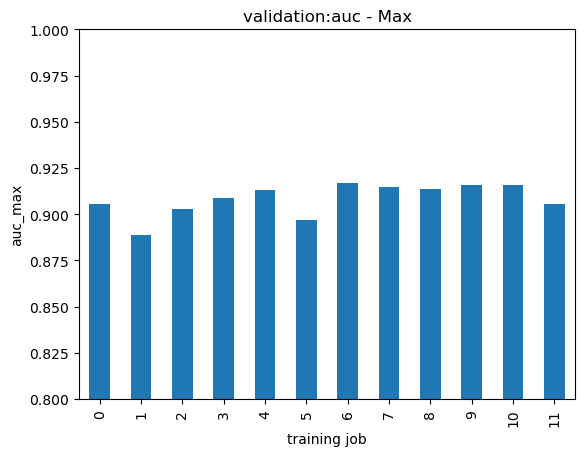

In [12]:
#visualize-tuning-results-auc-max
if run_component_analytics.dataframe()["validation:auc - Max"].iloc[1] != 0:
    run_component_analytics.dataframe()["validation:auc - Max"].plot(kind="bar", title="validation:auc - Max", xlabel="training job", ylabel="auc_max").set_ylim([0.8, 1]);
else:
    run_component_analytics.dataframe()["validation:auc - Last"].plot(kind="bar", title="validation:auc - Last", xlabel="training job", ylabel="auc_max").set_ylim([0.8, 1]);
    
plt.show()

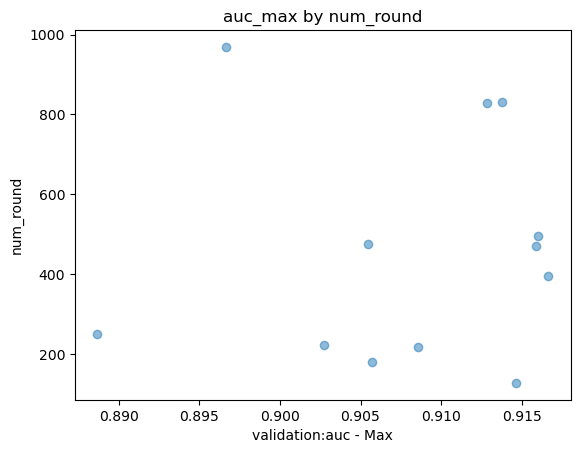

In [13]:
#visualize-tuning-results-auc-max-scatter
N = 12
if run_component_analytics.dataframe()["validation:auc - Max"].iloc[1] != 0:
    x = run_component_analytics.dataframe().sort_values(by=['TrialComponentName'])["validation:auc - Max"];
else:
    x = run_component_analytics.dataframe().sort_values(by=['TrialComponentName'])["validation:auc - Last"];
y = run_component_analytics.dataframe().sort_values(by=['TrialComponentName'])["num_round"]

plt.scatter(x, y, alpha=0.5)
plt.title("auc_max by num_round")
plt.xlabel("validation:auc - Max")
plt.ylabel("num_round");
plt.show()

Finally, can you print the best tuning, job based on your objective metric.

In [14]:
#print-best
tuner.best_training_job()

'lab-6-11051642-010-411c506c'

### Task 2.8: Graph experiment metrics with SageMaker Studio using built-in features

The previously mentioned method creates charts from experiment metrics using in line notebook cells. An additional option is to plot some of the experiment metrics using features within SageMaker Studio. Now that the experiment has run at least once, create a new bar chart in SageMaker Studio.

The next task opens a new tab in SageMaker Studio. To follow these directions, use one of the following options:
- **Option 1:** View the tabs side by side. To create a split screen view from the main SageMaker Studio window, either drag the **lab_6.ipynb** tab to the side or choose the **lab_6.ipynb** tab, and then from the toolbar, select **File** and **New View for Notebook**. You can now have the directions displayed as you explore the artifacts.
- **Option 2:** Switch between the SageMaker Studio tabs to follow these instructions. When you are finished exploring the artifacts, return to the notebook by choosing the **lab_6.ipynb** tab.

1. Choose the **SageMaker Home** icon.
1. Choose **Experiments**.

SageMaker Studio displays the **Experiments** tab.

1. Select the experiment that ends with *aws-tuning-job*.

SageMaker Studio displays the list of **Runs** included in that experiment.

1. On the column header row, select the option in the **Name** column.
1. Choose <span style="background-color:#1a1b22; font-size:90%; color:#57c4f8; position:relative; top:-1px; padding-top:3px; padding-bottom:3px; padding-left:10px; padding-right:10px; border-color:#57c4f8; border-width:thin; border-style:solid; border-radius:2px; margin-right:5px; white-space:nowrap">Analyze</span>.

SageMaker Studio displays the **Run Analyze Chart** tab.

1. On the lower half of the tab, in the chart section, choose <span style="background-color:#1a1b22; font-size:90%; color:#57c4f8; position:relative; top:-1px; padding-top:3px; padding-bottom:3px; padding-left:10px; padding-right:10px; border-color:#57c4f8; border-width:thin; border-style:solid; border-radius:2px; margin-right:5px; white-space:nowrap">+ Add Chart</span>.
1. Choose **Bar**.

SageMaker Studio displays the **Add Chart** window.

1. For **Y-axis**, choose **min_child_weight**.
1. Choose <span style="background-color:#73cdf9; font-size:90%;  color:black; position:relative; top:-1px; padding-top:3px; padding-bottom:3px; padding-left:10px; padding-right:10px; border-color:#57c4f8; border-radius:2px; border-width:3px; margin-right:5px; white-space:nowrap">Create</span>.

A bar chart showing *min_child_weight* per *run* in the experiment is now saved to the charts section.

1. Repeat this process and create a new bar chart for the **train:auc** metric.
1. Repeat this process and create a new bar chart for the **validation:auc** metric.

### Conclusion

Congratulations! You have used Amazon SageMaker Experiments to train and tune models. In the next lab, you use SageMaker Debugger to get insights on potential issues while training a model.

### Cleanup

You have completed this notebook. To move to the next part of the lab, do the following:

- Close this notebook file.
- Return to the lab session and continue with the **Conclusion**.